# Variational Inference

Variational inference's goal is to approximate a distribution $p(z|\theta)$ with a variational distribution $q(z|\lambda)$. Typically, the quality of approximiation is measured by the KL-divergence from $q$ to $p$. Note that the KL-divergence is note symmetric: $KL(q,p) \neq = KL(p,q)$

In practice, we minize another objection function called ELBO(q) which is defined as :

$$ELBO(q) = E_{q_\phi(z)}\big[ \log(p(x,z) - \log q_\phi (z) \big] $$

The assumptions for doing variational inference are:

1. log_prob of model can be evaluated
2. log_prob of guid can be evaluated
3. it is easy to sample from guide

# Pyro Stochastic Variational Inference

Pyro provides a very convenient way to perform stochastic variational inference.

```python
import pyro
from pyro.infer import SVI, Trace_ELBO
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
```
In Pyro terminology, $p$ is called *model* function. $q$ is called a *guide* function. 

And then training can be done as follows.

```python
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
    svi.step(data)
```

Enough with discussion, let's build some model ask some question and answer them with variational inference.

In [82]:
import pyro.distributions as dist
import torch
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

In [66]:
def model(data):
    # hyperparameters
    alpha0 = torch.tensor(10.0)
    beta0= torch.tensor(10.)
    f = pyro.sample("latent_fairness", dists.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i
        pyro.sample("obs_{}".format(i), dists.Bernoulli(f), obs=data[i])

Create some data

In [67]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

data

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.)]

In [68]:
def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [69]:
n_steps = 1000

In [70]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

..........

In [73]:
alpha_q, beta_q

(15.660024642944336, 14.290125846862793)

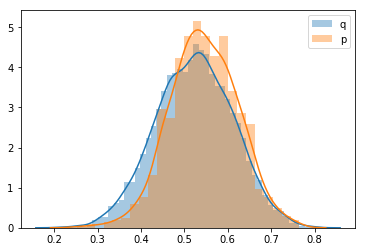

In [86]:
sns.distplot(dists.Beta(alpha_q, beta_q).sample((10000,)), label='q')
sns.distplot(dists.Beta(alpha_q + np.sum(data), beta_q + len(data) - np.sum(data)).sample((1000,)), 
             label='p')
plt.legend()